In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
data = []
# /home/jupyter-landy/data/Land_use/logs
folder_path = '/home/jupyter-landy/data/Land_use/logs'

In [3]:
# df_0 = pd.read_csv('/home/jupyter-landy/data/Land_use/logs/2.1-Tucker_decomposition_explore_ranks_gpu_0.log', sep='\t', header=None)
# df_1 = pd.read_csv('/home/jupyter-landy/data/Land_use/logs/2.1-Tucker_decomposition_explore_ranks_gpu_1.log', sep='\t', header=None)
# df_2 = pd.read_csv('/home/jupyter-landy/data/Land_use/logs/2.1-Tucker_decomposition_explore_ranks_gpu_2.log', sep='\t', header=None)
# df_3 = pd.read_csv('/home/jupyter-landy/data/Land_use/logs/2.1-Tucker_decomposition_explore_ranks.log', sep='\t', header=None)
# df_full = pd.concat([df_0, df_1, df_2, df_3], ignore_index=True)
# df_full.head()

In [4]:
for file in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep='\t', header=None)
    data.append(df)
    
df_full = pd.concat(data, ignore_index=True)
column_names=['rank_space', 'rank_app', 'rank_time', 'time', 'MSE', 'RMSE', 'L2 Norm Error']
df_full.columns = column_names
df_full.head(5)

,rank_space,rank_app,rank_time,time,MSE,RMSE,L2 Norm Error
0,3,3,3,2.65,0.0486,0.2206,1629.2768
1,3,3,4,2.83,0.0485,0.2203,1627.4821
2,3,3,5,2.78,0.0485,0.2202,1626.7353
3,3,3,6,2.71,0.0485,0.2201,1626.1756
4,3,3,7,2.92,0.0484,0.2201,1625.8308


In [5]:
len(df_full)

1000

In [6]:
df_full[(df_full['rank_space'] == 3) & df_full['MSE']<0.06]['MSE'].std()

0.0018238228257334362

In [7]:
sorted_space_df = df_full.sort_values(by=['rank_space'], ascending=False)
sorted_space_df.head(10)

,rank_space,rank_app,rank_time,time,MSE,RMSE,L2 Norm Error
999,12,12,12,2.89,0.0407,0.2018,1490.9006
936,12,6,9,2.94,0.0437,0.2090,1543.7871
926,12,5,9,2.83,0.0444,0.2108,1557.1377
927,12,5,10,2.68,0.0444,0.2107,1556.6267
928,12,5,11,2.98,0.0444,0.2107,1556.1979
929,12,5,12,2.82,0.0444,0.2106,1555.8446
930,12,6,3,2.96,0.0445,0.2110,1558.2893
931,12,6,4,2.99,0.0441,0.2100,1551.4675
932,12,6,5,2.82,0.0439,0.2096,1548.0097
933,12,6,6,2.93,0.0438,0.2094,1546.6592


In [8]:
df_full['sum'] = df_full['rank_space'] + df_full['rank_app'] + df_full['rank_time']

In [9]:
median_mse_population = df_full['MSE'].median()
median_mse_population

0.0445

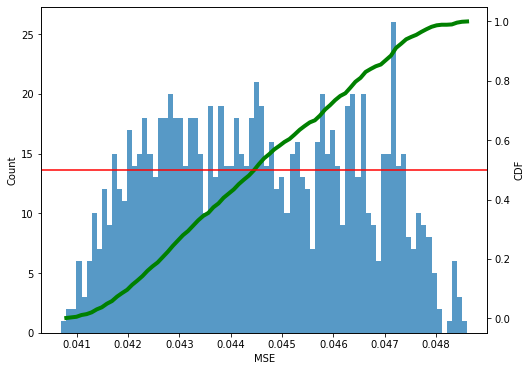

In [10]:
plt.figure(figsize=(8, 6))
count, bins, _ = plt.hist(df_full['MSE'], bins=80,alpha=0.75)
plt.ylabel('Count')
plt.xlabel('MSE')
counts = np.array(count)
cdf = np.cumsum(counts)
cdf /= cdf[-1]
ax_twin = plt.twinx()
ax_twin.plot(bins[1:], cdf, color='g',lw = 4)
ax_twin.axhline(y=0.50, color='r', linestyle='-')
ax_twin.set_ylabel('CDF')

#plt.title('CDF plot for MSE')
plt.show()

In [11]:
df_rank_space = sorted_space_df[['rank_space', 'MSE']].groupby(['rank_space']).agg(['median', 'std'])
df_rank_space.reset_index(inplace=True)
df_rank_space.head(2)

rank_space     MSE          
              median       std
0          3  0.0468  0.000645
1          4  0.0459  0.000857

In [12]:
df_rank_space.columns = ['rank_space', 'median', 'std']
df_rank_space.head(2)

,rank_space,median,std
0,3,0.0468,0.000645
1,4,0.0459,0.000857


In [13]:
#df_full.groupby(['rank_space'])['MSE'].agg(['max', 'min', 'mean', 'median', 'std'])

In [14]:
list_std_below_median_per_space_rank = []
list_std_above_median_per_space_rank = []
for row in df_rank_space.to_dict('records'):
    
    below_median_samples_std_space = df_full[(df_full['rank_space'] == row['rank_space']) & (df_full['MSE']<=row['median'])]['MSE'].std()
    above_median_samples_std_space = df_full[(df_full['rank_space'] == row['rank_space']) & (df_full['MSE']>row['median'])]['MSE'].std()
    list_std_below_median_per_space_rank.append(below_median_samples_std_space)
    list_std_above_median_per_space_rank.append(above_median_samples_std_space)

df_rank_space['std_below_median'] = list_std_below_median_per_space_rank
df_rank_space['std_above_median'] = list_std_above_median_per_space_rank

list_space_rank = df_rank_space['rank_space'].tolist()
list_median_mse_space = df_rank_space['median'].tolist()

low_lim_space = list(df_rank_space['median'] - df_rank_space['std_below_median'])
high_lim_space = list(df_rank_space['median'] + df_rank_space['std_above_median'])

In [15]:
df_rank_time = df_full.groupby(['rank_time'])['MSE'].agg(['median', 'std'])
df_rank_time.reset_index(inplace=True)

list_std_below_median_per_time_rank = []
list_std_above_median_per_time_rank = []
for row in df_rank_time.to_dict('records'):
    
    below_median_samples_std_time = df_full[(df_full['rank_time'] == row['rank_time']) & (df_full['MSE']<=row['median'])]['MSE'].std()
    above_median_samples_std_time = df_full[(df_full['rank_time'] == row['rank_time']) & (df_full['MSE']>row['median'])]['MSE'].std()
    list_std_below_median_per_time_rank.append(below_median_samples_std_time)
    list_std_above_median_per_time_rank.append(above_median_samples_std_time)

df_rank_time['std_below_median'] = list_std_below_median_per_time_rank
df_rank_time['std_above_median'] = list_std_above_median_per_time_rank


list_time_rank = df_rank_time['rank_time'].tolist()
list_median_mse_time = df_rank_time['median'].tolist()
low_lim_time = list(df_rank_time['median'] - df_rank_time['std_below_median'])
high_lim_time = list(df_rank_time['median'] + df_rank_time['std_above_median'])

In [16]:
df_rank_app = df_full.groupby(['rank_app'])['MSE'].agg(['median', 'std'])
df_rank_app.reset_index(inplace=True)
# df_rank_time.head(20)

list_std_below_median_per_app_rank = []
list_std_above_median_per_app_rank = []
for row in df_rank_app.to_dict('records'):
    
    below_median_samples_std_app = df_full[(df_full['rank_app'] == row['rank_app']) & (df_full['MSE']<=row['median'])]['MSE'].std()
    above_median_samples_std_app = df_full[(df_full['rank_app'] == row['rank_app']) & (df_full['MSE']>row['median'])]['MSE'].std()
    list_std_below_median_per_app_rank.append(below_median_samples_std_app)
    list_std_above_median_per_app_rank.append(above_median_samples_std_app)

df_rank_app['std_below_median'] = list_std_below_median_per_app_rank
df_rank_app['std_above_median'] = list_std_above_median_per_app_rank


list_app_rank = df_rank_app['rank_app'].tolist()
list_median_mse_app = df_rank_app['median'].tolist()
low_lim_app = list(df_rank_app['median'] - df_rank_app['std_below_median'])
high_lim_app = list(df_rank_app['median'] + df_rank_app['std_above_median'])

In [17]:
delta_space = np.diff(list_median_mse_space)
delta_time = np.diff(list_median_mse_time)
delta_app = np.diff(list_median_mse_app)
len(delta_space), len(delta_time), len(delta_app)

(9, 9, 9)

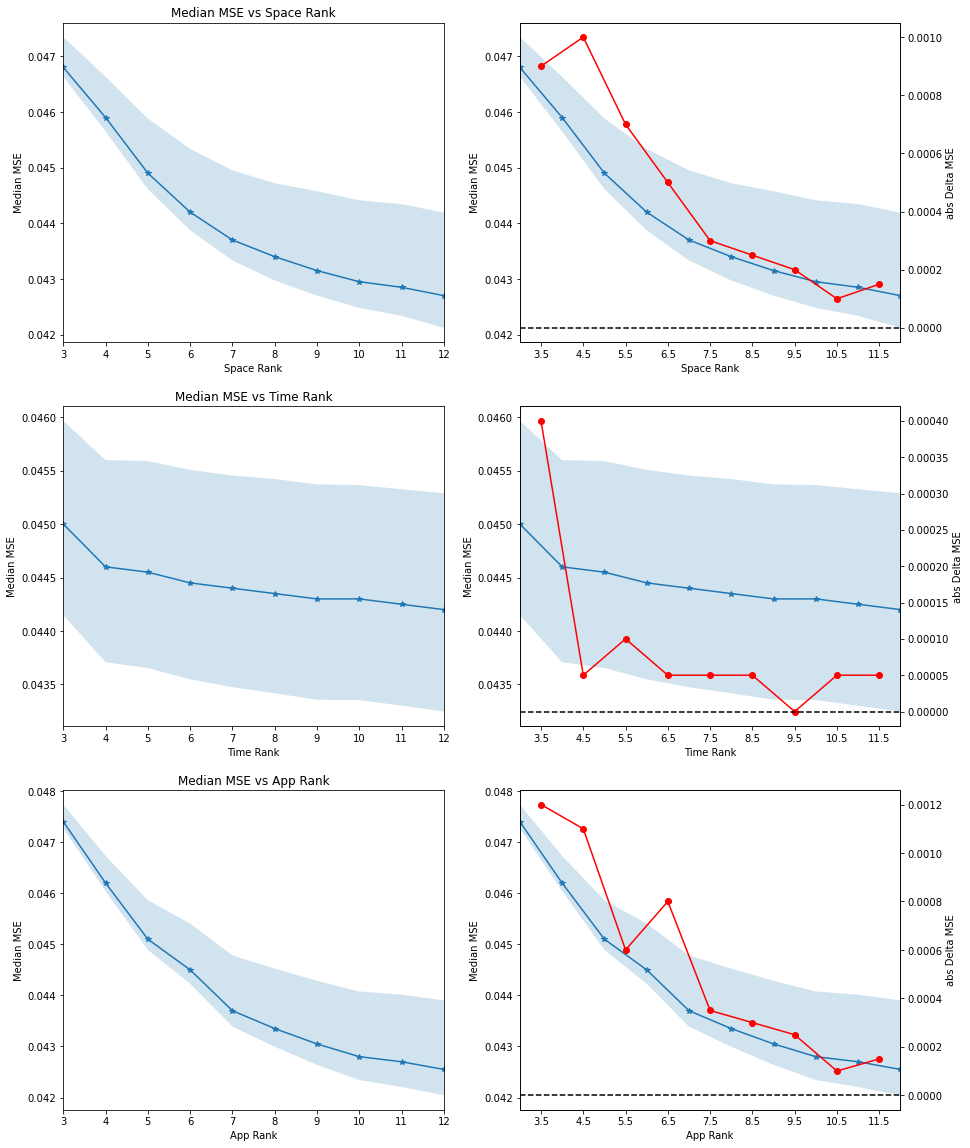

In [18]:
lim_x = (3,12)

fig , ax  = plt.subplots(3, 2, figsize=(15, 20))
ax = ax.flatten()
x =np.arange(3, 12,1)+.5

ax[0].plot(list_space_rank, list_median_mse_space, marker='*', label='Median')
ax[0].fill_between(list_space_rank, low_lim_space, high_lim_space, alpha=0.2, label='Std')
ax[0].set_xlabel('Space Rank')
ax[0].set_ylabel('Median MSE')
ax[0].set_title('Median MSE vs Space Rank')
ax[0].set_xlim(lim_x[0], lim_x[1])

ax[2].plot(list_time_rank, list_median_mse_time, marker='*', label='Median')
ax[2].fill_between(list_time_rank, low_lim_time, high_lim_time, alpha=0.2, label='Std')
ax[2].set_xlabel('Time Rank')
ax[2].set_ylabel('Median MSE')
ax[2].set_title('Median MSE vs Time Rank')
ax[2].set_xlim(lim_x[0], lim_x[1])

ax[4].plot(list_app_rank, list_median_mse_app, marker='*', label='Median')
ax[4].fill_between(list_app_rank, low_lim_app, high_lim_app, alpha=0.2, label='Std')
ax[4].set_xlabel('App Rank')
ax[4].set_ylabel('Median MSE')
ax[4].set_title('Median MSE vs App Rank')
ax[4].set_xlim(lim_x[0], lim_x[1])


# delta_space = np.gradient(list_median_mse_space)
# ax[1].plot(x, delta_space, marker='o')
# ax[1].set_xticks(x)

ax[1].plot(list_space_rank, list_median_mse_space, marker='*', label='Median')
ax[1].fill_between(list_space_rank, low_lim_space, high_lim_space, alpha=0.2, label='Std')
ax[1].set_xlabel('Space Rank')
ax[1].set_ylabel('Median MSE')
#ax[1].set_title('Median MSE vs Space Rank')
ax[1].set_xlim(lim_x[0], lim_x[1])
ax_twin = ax[1].twinx()
ax_twin.plot(x, abs(delta_space), marker='o', color='red')
ax_twin.axhline(y=0, color='black', linestyle='--')
ax_twin.set_ylabel('abs Delta MSE')
ax_twin.set_xticks(x)

# delta_time = np.gradient(list_median_mse_time)
# ax[3].plot(x, delta_time, marker='o')
# ax[3].set_xticks(x)

ax[3].plot(list_time_rank, list_median_mse_time, marker='*', label='Median')
ax[3].fill_between(list_time_rank, low_lim_time, high_lim_time, alpha=0.2, label='Std')
ax[3].set_xlabel('Time Rank')
ax[3].set_ylabel('Median MSE')
#ax[3].set_title('Median MSE vs Rank Time')
ax[3].set_xlim(lim_x[0], lim_x[1])
ax_twin = ax[3].twinx()
ax_twin.plot(x, abs(delta_time), marker='o', color='red')
ax_twin.axhline(y=0, color='black', linestyle='--')
ax_twin.set_ylabel('abs Delta MSE')
ax_twin.set_xticks(x)

# delta_app = np.gradient(list_median_mse_app)
# ax[5].plot(x, delta_app, marker='o')
# ax[5].set_xticks(x)

ax[5].plot(list_app_rank, list_median_mse_app, marker='*', label='Median')
ax[5].fill_between(list_app_rank, low_lim_app, high_lim_app, alpha=0.2, label='Std')
#ax[5].scatter([2+2], [list_median_mse_app[2]], marker='*', color='red', s=150, label='Best App', zorder=10)
ax[5].set_xlabel('App Rank')
ax[5].set_ylabel('Median MSE')
#ax[5].set_title('Median MSE vs Rank App')
ax[5].set_xlim(lim_x[0], lim_x[1])
ax_twin = ax[5].twinx()
ax_twin.plot(x, abs(delta_app), marker='o', color='red')
ax_twin.axhline(y=0, color='black', linestyle='--')
ax_twin.set_ylabel('abs Delta MSE')
ax_twin.set_xticks(x)



plt.show()

No handles with labels found to put in legend.


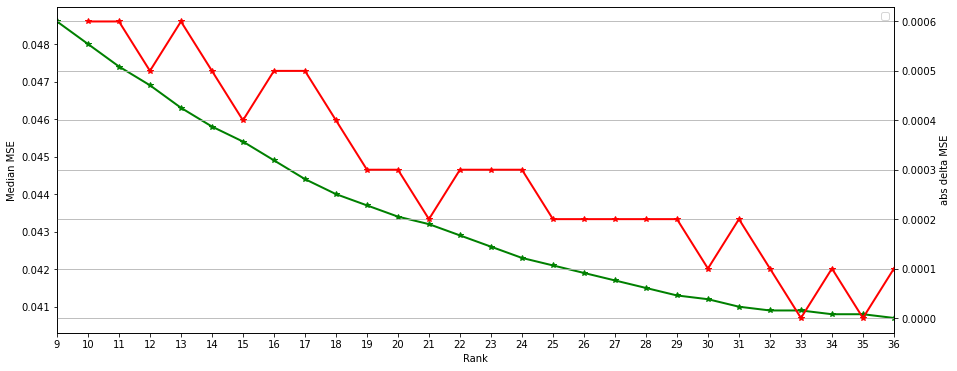

In [19]:
df_full['sum_rank'] = df_full['rank_space'] + df_full['rank_app'] + df_full['rank_time']

df_sum = df_full.groupby(['sum_rank'])['MSE'].agg(['max', 'min', 'mean', 'median', 'std'])
df_sum.reset_index(inplace=True)

sum_rank = df_sum['sum_rank'].tolist()
list_median_mse_sum = df_sum['min'].tolist()

plt.figure(figsize=(15, 6))
plt.plot(sum_rank, list_median_mse_sum, color='g', lw=2,  marker = '*')

#xticks = np.arange(6, 60, 2)
plt.xlabel('Rank')

plt.ylabel('Median MSE')
plt.legend()
ax = plt.twinx()
ax.plot(sum_rank[1:], abs(np.diff(list_median_mse_sum)), color='r', lw=2, marker = '*')
ax.set_ylabel('abs delta MSE')
# ax.axvline(x=13, color='b', linestyle='--')
ax.grid()
#plt.xticks(xticks.tolist())
plt.xticks(sum_rank)
plt.xlim(9, 36)
plt.show()

In [20]:
temp = df_full[df_full['sum_rank']==13].sort_values(by=['MSE'])
temp.head()

,rank_space,rank_app,rank_time,time,MSE,RMSE,L2 Norm Error,sum,sum_rank
220,5,5,3,2.62,0.0463,0.2151,1588.8506,13,13
121,4,5,4,2.88,0.0466,0.2158,1594.3448,13,13
130,4,6,3,2.70,0.0466,0.2159,1595.0816,13,13
211,5,4,4,2.80,0.0468,0.2164,1598.4263,13,13
310,6,4,3,2.76,0.0468,0.2164,1598.1583,13,13


In [21]:
df_full['sum_rank'].min(), df_full['sum_rank'].max()

(9, 36)

In [22]:
df_full[df_full['sum_rank'] == 14].sort_values(by=['MSE']).head(10)

,rank_space,rank_app,rank_time,time,MSE,RMSE,L2 Norm Error,sum,sum_rank
230,5,6,3,2.81,0.0458,0.2141,1581.2336,14,14
320,6,5,3,2.94,0.0459,0.2142,1582.5261,14,14
221,5,5,4,2.96,0.0460,0.2144,1583.8484,14,14
131,4,6,4,2.96,0.0463,0.2153,1590.2400,14,14
140,4,7,3,2.61,0.0464,0.2155,1591.6466,14,14
122,4,5,5,2.89,0.0465,0.2157,1592.9921,14,14
410,7,4,3,2.96,0.0466,0.2159,1595.0819,14,14
311,6,4,4,2.78,0.0466,0.2158,1594.3921,14,14
212,5,4,5,2.60,0.0467,0.2162,1596.8338,14,14
41,3,7,4,2.93,0.0470,0.2168,1601.6494,14,14


In [23]:
(5000*4/60/24/3)*0.66

3.0555555555555554

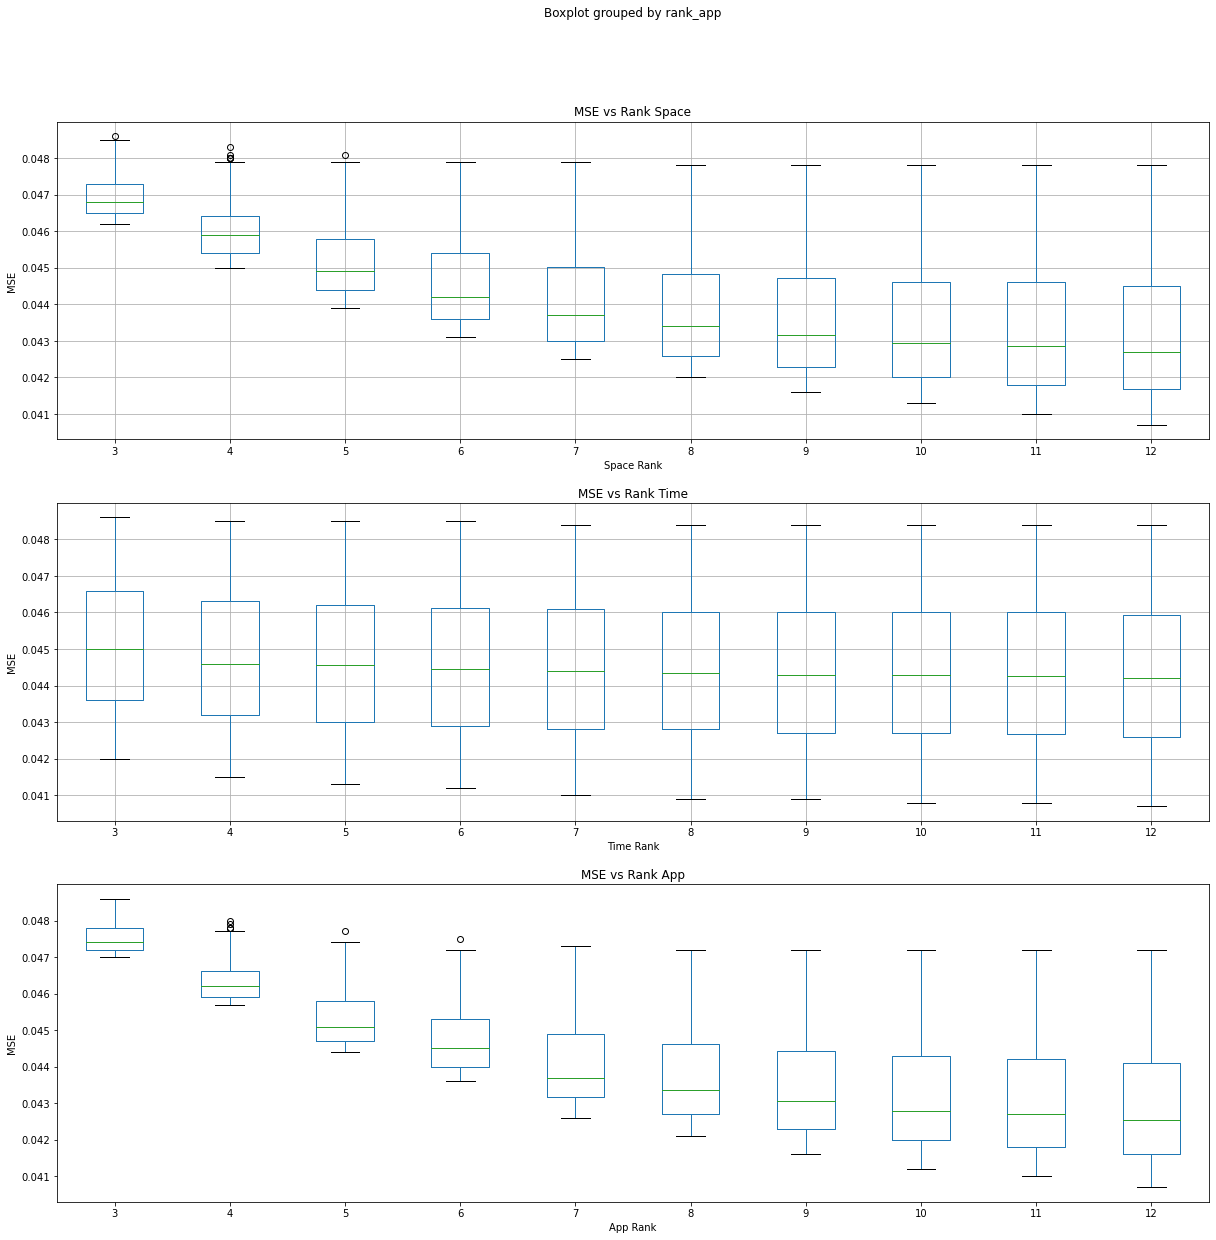

In [24]:
fig , ax  = plt.subplots(3, 1, figsize=(20, 20))

df_full.boxplot("MSE", by ='rank_space', ax=ax.flatten()[0])
ax[0].set_xlabel('Space Rank')
ax[0].set_ylabel('MSE')
ax[0].set_title('MSE vs Rank Space')

df_full.boxplot("MSE", by ='rank_time', ax=ax.flatten()[1])
ax[1].set_xlabel('Time Rank')
ax[1].set_ylabel('MSE')
ax[1].set_title('MSE vs Rank Time')

df_full.boxplot("MSE", by ='rank_app', ax=ax.flatten()[2])
ax[2].set_xlabel('App Rank')
ax[2].set_ylabel('MSE')
ax[2].set_title('MSE vs Rank App')
ax[2].grid(alpha=0.25)
plt.show()


#### Analysis on Minimum MSE

In [25]:
df_full.head()

,rank_space,rank_app,rank_time,time,MSE,RMSE,L2 Norm Error,sum,sum_rank
0,3,3,3,2.65,0.0486,0.2206,1629.2768,9,9
1,3,3,4,2.83,0.0485,0.2203,1627.4821,10,10
2,3,3,5,2.78,0.0485,0.2202,1626.7353,11,11
3,3,3,6,2.71,0.0485,0.2201,1626.1756,12,12
4,3,3,7,2.92,0.0484,0.2201,1625.8308,13,13


In [40]:
df_min_mse_sum_rank = df_full[['sum_rank','MSE']].groupby('sum_rank').min()
df_min_mse_sum_rank.sort_values(by='MSE', ascending=False).head(10)

,MSE
sum_rank,
9,0.0486
10,0.0480
11,0.0474
12,0.0469
13,0.0463
14,0.0458
15,0.0454
16,0.0449
17,0.0444


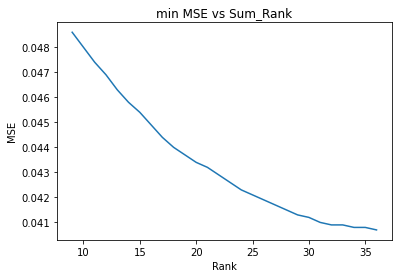

In [41]:
df_min_mse_sum_rank.reset_index(inplace=True)
plt.plot(df_min_mse_sum_rank['sum_rank'].tolist(), df_min_mse_sum_rank['MSE'].tolist())
plt.xlabel('Rank')
plt.ylabel('MSE')
plt.title('min MSE vs Sum_Rank')
plt.show()